# Temat: Pali się

https://www.kaggle.com/datasets/gatandubuc/public-transport-traffic-data-in-france

## Cel -> wykrycie sytuacji w której pożar zagraża ludziom

## Stakeholder -> straż pożarna pracująca nad systemem wczesnego ostrzegania oraz reagowania na zagrożenia pożarowe



#### Doczytać o niezbilansowanych zbiorach danych
#### [przegląd różnych metod]
#### Test - zbudować model bez żadnego bilansowania
#### Benchmark - zrobienie minimum i zbudowanie modelu benchmarkowego [usunięcie braków, zamiana zmiennych kategorycznych]
#### Zmienne kategoryczne - zacząć od label encodingu AS-IS, w drugiej kolejności ewentualnie zrobić grupowanie

#### Import bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc 

import xgboost as xgb

import Functions_ML as my_functions

%matplotlib inline

In [2]:
df = pd.read_csv('Fire-Incidents.csv')

pd.set_option('display.max_columns', None)

### Usunięcie niepotrzebnych kolumn

In [3]:
col_to_drop = ['Business_Impact', 'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
                'Ext_agent_app_or_defer_time', 'Last_TFS_Unit_Clear_Time']

df = df.drop(columns = col_to_drop, axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11214 entries, 0 to 11213
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Area_of_Origin                            11214 non-null  object 
 1   Civilian_Casualties                       11214 non-null  int64  
 2   Count_of_Persons_Rescued                  11214 non-null  int64  
 3   Extent_Of_Fire                            11214 non-null  object 
 4   Fire_Alarm_System_Impact_on_Evacuation    11214 non-null  object 
 5   Fire_Alarm_System_Operation               11214 non-null  object 
 6   Fire_Alarm_System_Presence                11214 non-null  object 
 7   Fire_Under_Control_Time                   11214 non-null  object 
 8   Ignition_Source                           11214 non-null  object 
 9   Incident_Station_Area                     11214 non-null  int64  
 10  Incident_Ward                     

### Usunięcie pustych wierszy

In [4]:
df.isna().sum()

Area_of_Origin                               0
Civilian_Casualties                          0
Count_of_Persons_Rescued                     0
Extent_Of_Fire                               0
Fire_Alarm_System_Impact_on_Evacuation       0
Fire_Alarm_System_Operation                  0
Fire_Alarm_System_Presence                   0
Fire_Under_Control_Time                      0
Ignition_Source                              0
Incident_Station_Area                        0
Incident_Ward                               33
Latitude                                     0
Longitude                                    0
Material_First_Ignited                       0
Method_Of_Fire_Control                       0
Possible_Cause                               0
Property_Use                                 0
Smoke_Alarm_at_Fire_Origin_Alarm_Failure     0
Smoke_Alarm_at_Fire_Origin_Alarm_Type        0
Status_of_Fire_On_Arrival                    0
TFS_Alarm_Time                               0
TFS_Arrival_T

In [5]:
df.dropna(inplace = True)

### Zmiana typu danych na datetime

In [6]:
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11181 entries, 0 to 11213
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Area_of_Origin                            11181 non-null  object        
 1   Civilian_Casualties                       11181 non-null  int64         
 2   Count_of_Persons_Rescued                  11181 non-null  int64         
 3   Extent_Of_Fire                            11181 non-null  object        
 4   Fire_Alarm_System_Impact_on_Evacuation    11181 non-null  object        
 5   Fire_Alarm_System_Operation               11181 non-null  object        
 6   Fire_Alarm_System_Presence                11181 non-null  object        
 7   Fire_Under_Control_Time                   11181 non-null  object        
 8   Ignition_Source                           11181 non-null  object        
 9   Incident_Station_Area            

### Civilian_Casualties -> Y 
#### Civilian_Casualties, if value >= 1 set 1

In [8]:
df.loc[df['Civilian_Casualties'] >= 1, 'Civilian_Casualties'] = 1

In [9]:
df.head()

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time
0,Porch or Balcony,0,86,Confined to object of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system did not operate,Fire alarm system present,2018-08-24T17:06:28,Undetermined,114,18.0,43.760357,-79.412479,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Fire with smoke showing only - including vehic...,2018-08-24 16:49:36,2018-08-24 16:54:09
1,Cooking Area or Kitchen,0,28,Confined to part of room/area of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system operated,Fire alarm system present,2018-11-24T07:19:00,"Other Cooking Items (eg Toaster, Kettle, elec ...",142,7.0,43.754542,-79.530419,Plastic,Extinguished by occupant,Under Investigation,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire extinguished prior to arrival,2018-11-24 07:09:12,2018-11-24 07:14:23
2,"Living Area (e.g. living, TV, recreation, etc)",1,16,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2017-02-09T18:36:21,Undetermined,325,27.0,43.657300,-79.373460,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Flames showing from small area (one storey or ...,2017-02-09 17:45:07,2017-02-09 17:48:49
3,Undetermined (formerly 98),0,12,Entire Structure,Undetermined,Fire alarm system operation undetermined,Undetermined,2012-10-30T01:28:48,Undetermined,332,20.0,43.649350,-79.393700,Undetermined (formerly 98),Extinguished by fire department,Undetermined,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,Flames showing from large area (more than one ...,2012-10-30 00:42:01,2012-10-30 00:44:58
4,"Sleeping Area or Bedroom (inc. patients room, ...",1,11,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2018-07-08T04:38:28,Matches or Lighters (unable to distinguish),442,5.0,43.697960,-79.511539,Bedding,Extinguished by fire department,Suspected Arson,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire with no evidence from street,2018-07-08 04:08:50,2018-07-08 04:13:54


In [10]:
df['Civilian_Casualties'].value_counts()

Civilian_Casualties
0    10233
1      948
Name: count, dtype: int64

In [11]:
df['Property_Use'].value_counts().head(25)

Property_Use
Multi-Unit Dwelling - Over 12 Units                              3716
Detached Dwelling                                                2309
Semi-Detached Dwelling                                            727
Attached Dwelling (eg. rowhouse, townhouse, etc.)                 577
Multi-Unit Dwelling - 2 to 6 Units                                279
Apartment, Flat, Tenement with Business                           276
Restaurants (occupant load greater than 30 persons, licensed)     229
Restaurant (occupant load less than 30 persons)                   164
Multi-Unit Dwelling - 7 to 12 Units                               145
Detached Garage                                                   134
Subway Station                                                    131
Rooming/Boarding/Lodging House                                    121
General Business Office                                           119
Motor Vehicle Repair Garage                                       113
Other B

### Calculating the time when the fire brigade arrived

In [12]:
df['Response'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']) / pd.Timedelta(minutes = 1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11181 entries, 0 to 11213
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Area_of_Origin                            11181 non-null  object        
 1   Civilian_Casualties                       11181 non-null  int64         
 2   Count_of_Persons_Rescued                  11181 non-null  int64         
 3   Extent_Of_Fire                            11181 non-null  object        
 4   Fire_Alarm_System_Impact_on_Evacuation    11181 non-null  object        
 5   Fire_Alarm_System_Operation               11181 non-null  object        
 6   Fire_Alarm_System_Presence                11181 non-null  object        
 7   Fire_Under_Control_Time                   11181 non-null  object        
 8   Ignition_Source                           11181 non-null  object        
 9   Incident_Station_Area            

### Set 'Property_use' string value 'Business' or 'Non-Business' based on Dwelling

In [14]:
df['Property_Use_Category'] = df['Property_Use'].apply(my_functions.classification)

In [15]:
df.head()

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,Response,Property_Use_Category
0,Porch or Balcony,0,86,Confined to object of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system did not operate,Fire alarm system present,2018-08-24T17:06:28,Undetermined,114,18.0,43.760357,-79.412479,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Fire with smoke showing only - including vehic...,2018-08-24 16:49:36,2018-08-24 16:54:09,4.550000,Business
1,Cooking Area or Kitchen,0,28,Confined to part of room/area of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system operated,Fire alarm system present,2018-11-24T07:19:00,"Other Cooking Items (eg Toaster, Kettle, elec ...",142,7.0,43.754542,-79.530419,Plastic,Extinguished by occupant,Under Investigation,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire extinguished prior to arrival,2018-11-24 07:09:12,2018-11-24 07:14:23,5.183333,Non-Business
2,"Living Area (e.g. living, TV, recreation, etc)",1,16,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2017-02-09T18:36:21,Undetermined,325,27.0,43.657300,-79.373460,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Flames showing from small area (one storey or ...,2017-02-09 17:45:07,2017-02-09 17:48:49,3.700000,Business
3,Undetermined (formerly 98),0,12,Entire Structure,Undetermined,Fire alarm system operation undetermined,Undetermined,2012-10-30T01:28:48,Undetermined,332,20.0,43.649350,-79.393700,Undetermined (formerly 98),Extinguished by fire department,Undetermined,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,Flames showing from large area (more than one ...,2012-10-30 00:42:01,2012-10-30 00:44:58,2.950000,Non-Business
4,"Sleeping Area or Bedroom (inc. patients room, ...",1,11,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2018-07-08T04:38:28,Matches or Lighters (unable to distinguish),442,5.0,43.697960,-79.511539,Bedding,Extinguished by fire department,Suspected Arson,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire with no evidence from street,2018-07-08 04:08:50,2018-07-08 04:13:54,5.066667,Business


### Encode string columns to number

In [16]:
label_encoder = LabelEncoder()

def encode(columns_encode):
    for col in columns_encode:
        df[col] = label_encoder.fit_transform(df[col])
    return df


In [17]:
columns_encode = ['Area_of_Origin', 'Extent_Of_Fire', 'Fire_Alarm_System_Impact_on_Evacuation',
                 'Ignition_Source', 'Material_First_Ignited', 'Method_Of_Fire_Control', 'Possible_Cause', 'Status_of_Fire_On_Arrival']

In [18]:
encode(columns_encode)

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,Response,Property_Use_Category
0,51,0,86,0,4,Fire alarm system did not operate,Fire alarm system present,2018-08-24T17:06:28,75,114,18.0,43.760357,-79.412479,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),3,2018-08-24 16:49:36,2018-08-24 16:54:09,4.550000,Business
1,11,0,28,1,4,Fire alarm system operated,Fire alarm system present,2018-11-24T07:19:00,48,142,7.0,43.754542,-79.530419,41,3,18,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-11-24 07:09:12,2018-11-24 07:14:23,5.183333,Non-Business
2,31,1,16,8,5,Fire alarm system operated,Fire alarm system present,2017-02-09T18:36:21,75,325,27.0,43.657300,-79.373460,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),5,2017-02-09 17:45:07,2017-02-09 17:48:49,3.700000,Business
3,70,0,12,3,6,Fire alarm system operation undetermined,Undetermined,2012-10-30T01:28:48,75,332,20.0,43.649350,-79.393700,49,2,19,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,4,2012-10-30 00:42:01,2012-10-30 00:44:58,2.950000,Non-Business
4,62,1,11,8,5,Fire alarm system operated,Fire alarm system present,2018-07-08T04:38:28,40,442,5.0,43.697960,-79.511539,4,2,14,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,2,2018-07-08 04:08:50,2018-07-08 04:13:54,5.066667,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11209,66,0,0,0,0,Fire alarm system operated,Fire alarm system present,2018-02-23T14:50:16,75,313,13.0,43.667295,-79.373778,45,1,6,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),2,2018-02-23 14:35:03,2018-02-23 14:38:33,3.500000,Business
11210,45,0,0,0,0,Fire alarm system operated,Fire alarm system present,2018-02-24T02:04:10,12,222,20.0,43.729364,-79.280725,49,3,2,General Business Office,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-02-24 01:30:45,2018-02-24 01:36:59,6.233333,Non-Business
11211,45,0,0,0,0,Fire alarm system operated,Fire alarm system present,2018-02-24T02:40:00,10,222,20.0,43.729364,-79.280725,14,3,10,General Business Office,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-02-24 02:30:33,2018-02-24 02:35:07,4.566667,Non-Business
11212,51,1,0,1,0,Fire alarm system operated,Fire alarm system present,2018-02-24T00:48:11,65,141,7.0,43.763361,-79.500863,40,2,6,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Battery operated,5,2018-02-24 00:34:12,2018-02-24 00:38:47,4.583333,Business


### Encoding chosen Fire alarm columns to binary values 

In [19]:
df = pd.get_dummies(df, columns = ['Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Property_Use_Category'])

df.head()

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,Response,Fire_Alarm_System_Operation_Fire alarm system did not operate,Fire_Alarm_System_Operation_Fire alarm system operated,Fire_Alarm_System_Operation_Fire alarm system operation undetermined,Fire_Alarm_System_Operation_Not applicable (no system),Fire_Alarm_System_Presence_Fire alarm system present,Fire_Alarm_System_Presence_No Fire alarm system,Fire_Alarm_System_Presence_Not applicable (bldg not classified by OBC OR detached/semi/town home),Fire_Alarm_System_Presence_Undetermined,Property_Use_Category_Business,Property_Use_Category_Non-Business
0,51,0,86,0,4,2018-08-24T17:06:28,75,114,18.0,43.760357,-79.412479,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),3,2018-08-24 16:49:36,2018-08-24 16:54:09,4.550000,True,False,False,False,True,False,False,False,True,False
1,11,0,28,1,4,2018-11-24T07:19:00,48,142,7.0,43.754542,-79.530419,41,3,18,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-11-24 07:09:12,2018-11-24 07:14:23,5.183333,False,True,False,False,True,False,False,False,False,True
2,31,1,16,8,5,2017-02-09T18:36:21,75,325,27.0,43.657300,-79.373460,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),5,2017-02-09 17:45:07,2017-02-09 17:48:49,3.700000,False,True,False,False,True,False,False,False,True,False
3,70,0,12,3,6,2012-10-30T01:28:48,75,332,20.0,43.649350,-79.393700,49,2,19,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,4,2012-10-30 00:42:01,2012-10-30 00:44:58,2.950000,False,False,True,False,False,False,False,True,False,True
4,62,1,11,8,5,2018-07-08T04:38:28,40,442,5.0,43.697960,-79.511539,4,2,14,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,2,2018-07-08 04:08:50,2018-07-08 04:13:54,5.066667,False,True,False,False,True,False,False,False,True,False


## Prepare to create model

In [20]:
df_two = df.copy()

In [21]:
df_two['Fire_Alarm_System_Presence_No Fire alarm system'].value_counts()

Fire_Alarm_System_Presence_No Fire alarm system
False    9393
True     1788
Name: count, dtype: int64

In [22]:
col_to_drop = ['Fire_Under_Control_Time', 'Property_Use', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
                'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'TFS_Alarm_Time', 'TFS_Arrival_Time']


In [23]:
df_two.drop(columns = col_to_drop, inplace = True)

In [24]:
df_two.sample(10)

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Status_of_Fire_On_Arrival,Response,Fire_Alarm_System_Operation_Fire alarm system did not operate,Fire_Alarm_System_Operation_Fire alarm system operated,Fire_Alarm_System_Operation_Fire alarm system operation undetermined,Fire_Alarm_System_Operation_Not applicable (no system),Fire_Alarm_System_Presence_Fire alarm system present,Fire_Alarm_System_Presence_No Fire alarm system,Fire_Alarm_System_Presence_Not applicable (bldg not classified by OBC OR detached/semi/town home),Fire_Alarm_System_Presence_Undetermined,Property_Use_Category_Business,Property_Use_Category_Non-Business
1884,51,0,0,1,4,75,143,6.0,43.757777,-79.439044,49,3,20,1,4.666667,True,False,False,False,True,False,False,False,True,False
4194,11,0,0,0,6,57,114,23.0,43.777050,-79.427770,41,2,10,2,4.000000,False,False,True,False,True,False,False,False,True,False
1665,11,0,0,1,4,69,244,22.0,43.790441,-79.302295,10,1,5,5,5.533333,False,True,False,False,True,False,False,False,False,True
9522,11,0,0,1,0,69,115,33.0,43.769430,-79.343170,7,3,17,1,6.050000,False,False,True,False,False,False,False,True,True,False
9985,11,1,0,9,0,57,125,26.0,43.715310,-79.329650,40,4,17,1,6.650000,False,True,False,False,True,False,False,False,False,True
6409,11,0,0,0,4,14,232,37.0,43.752070,-79.262460,10,2,5,2,4.050000,True,False,False,False,True,False,False,False,False,True
3367,17,0,0,0,4,75,332,20.0,43.643300,-79.398250,21,3,19,3,4.466667,False,False,False,True,False,True,False,False,True,False
10688,72,0,0,1,4,49,227,32.0,43.673820,-79.281860,14,3,2,1,4.700000,False,False,False,True,False,True,False,False,True,False
1554,31,0,0,0,2,65,343,12.0,43.684455,-79.421442,23,2,19,3,5.000000,False,True,False,False,True,False,False,False,True,False
1890,11,0,0,1,5,69,325,13.0,43.655149,-79.374971,45,2,14,3,4.200000,False,True,False,False,True,False,False,False,False,True


## Assign 'Civilian_Casualties' to y

In [25]:
X = df_two.drop(columns = 'Civilian_Casualties')
y = df_two['Civilian_Casualties']

## Split into training and test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

# LogisticRegression Model

In [27]:
model = LogisticRegression(random_state= 42)

In [28]:
# Fit train data
model.fit(X_train, y_train)

C:\Users\marci\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [29]:
y_pred = model.predict(X_test)

In [30]:
#metrics.r2_score(y_test, y_pred)

### Normalizacja

In [31]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
#model = RandomForestClassifier(n_estimators = 100, random_state = 42)
#model.fit(X_train, y_train)


### classification_report

In [33]:
cl_name = ['No casulties', 'Casulties']

report = classification_report(y_test, y_pred, target_names = cl_name, output_dict = True)
final_report = pd.DataFrame(report).transpose()

final_report 

,precision,recall,f1-score,support
No casulties,0.916629,0.997561,0.955384,2050.000000
Casulties,0.166667,0.005348,0.010363,187.000000
accuracy,0.914618,0.914618,0.914618,0.914618
macro avg,0.541648,0.501454,0.482873,2237.000000
weighted avg,0.853937,0.914618,0.876386,2237.000000


In [34]:
print(confusion_matrix(y_test, y_pred))

[[2045    5]
 [ 186    1]]


In [35]:
print(accuracy_score(y_test, y_pred))

0.9146177916852928


In [36]:
pred_train = model.predict_proba(X_train)

C:\Users\marci\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


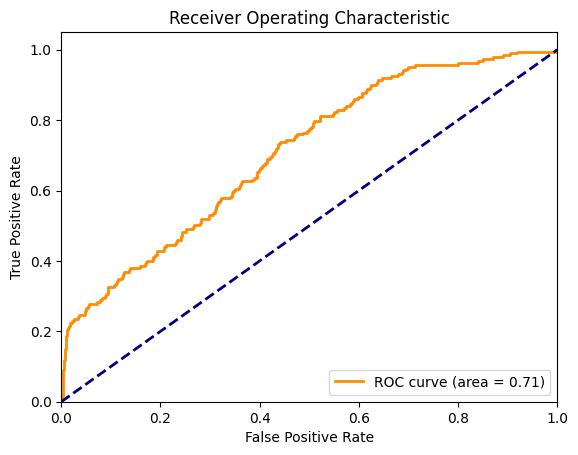

In [37]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Obliczanie wartości FPR, TPR oraz progu
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# XgBoost

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import xgboost as xgb

In [39]:
df_two.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11181 entries, 0 to 11213
Data columns (total 25 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   Area_of_Origin                                                                                     11181 non-null  int32  
 1   Civilian_Casualties                                                                                11181 non-null  int64  
 2   Count_of_Persons_Rescued                                                                           11181 non-null  int64  
 3   Extent_Of_Fire                                                                                     11181 non-null  int32  
 4   Fire_Alarm_System_Impact_on_Evacuation                                                             11181 non-null  int32  


In [40]:
X = df_two.drop(columns=['Civilian_Casualties'])
y = df_two['Civilian_Casualties']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [42]:
# Zastosowanie SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [43]:
model_2 = xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
model_2.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [44]:
y_pred = model_2.predict(X_test)

In [45]:
y_pred = model_2.predict(X_test)
report = classification_report(y_test, y_pred, target_names=cl_name, output_dict=True)
final_report = pd.DataFrame(report).transpose()

print(final_report)

              precision    recall  f1-score      support
No casulties   0.938561  0.916585  0.927443  2050.000000
Casulties      0.272340  0.342246  0.303318   187.000000
accuracy       0.868574  0.868574  0.868574     0.868574
macro avg      0.605451  0.629416  0.615380  2237.000000
weighted avg   0.882869  0.868574  0.875270  2237.000000


# Drzewo decyzyjne (Decision Tree)

In [46]:
# Podział danych na cechy i etykiety
X = df_two.drop(columns=['Civilian_Casualties'])
y = df_two['Civilian_Casualties']

In [47]:
# Podział danych na zestawy treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Zastosowanie SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [49]:
# Inicjalizacja i trening modelu drzewa decyzyjnego
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [50]:
# Generowanie predykcji
y_pred = model_dt.predict(X_test)

In [51]:
# Ocena modelu
cl_name = ['No casualties', 'Casualties']
report = classification_report(y_test, y_pred, target_names=cl_name, output_dict=True)
final_report = pd.DataFrame(report).transpose()
print(final_report)

               precision    recall  f1-score      support
No casualties   0.932136  0.911220  0.921559  2050.000000
Casualties      0.218884  0.272727  0.242857   187.000000
accuracy        0.857845  0.857845  0.857845     0.857845
macro avg       0.575510  0.591973  0.582208  2237.000000
weighted avg    0.872512  0.857845  0.864823  2237.000000


# GridSearchCV

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [53]:
# Podział danych na cechy i etykiety
X = df_two.drop(columns='Civilian_Casualties')
y = df_two['Civilian_Casualties']

In [54]:
# Podział danych na zestawy treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Zastosowanie SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [56]:
# Normalizacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
# Definicja modelu
model = LogisticRegression(random_state=42)

In [58]:
# Siatka hiperparametrów
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

In [59]:
# Inicjalizacja GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision')

In [60]:
# Trening modelu GridSearchCV
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced']},
             scoring='precision')

In [61]:
# Wybór najlepszego modelu
best_model = grid_search.best_estimator_

In [62]:
# Generowanie predykcji
y_pred = best_model.predict(X_test_scaled)

In [63]:
# Ocena modelu
cl_name = ['No casualties', 'Casualties']
report = classification_report(y_test, y_pred, target_names=cl_name, output_dict=True)
final_report = pd.DataFrame(report).transpose()

print(final_report)

               precision    recall  f1-score      support
No casualties   0.920162  0.995122  0.956175  2050.000000
Casualties      0.500000  0.053476  0.096618   187.000000
accuracy        0.916406  0.916406  0.916406     0.916406
macro avg       0.710081  0.524299  0.526397  2237.000000
weighted avg    0.885039  0.916406  0.884321  2237.000000


In [64]:
# Wyodrębnienie lat
df['Year'] = df['TFS_Alarm_Time'].dt.year

# Wyodrębnienie unikalnych lat i ich posortowanie
unique_years = sorted(df['Year'].unique())

print("Unikalne lata rosnąco:")
print(unique_years)

Unikalne lata rosnąco:
[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [65]:
df.shape[0]

11181

In [66]:
df['Casualties'].corr()

KeyError: 'Casualties'